<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/bert_finetuning_YouTube_clickbait_domain_adaption_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Tue Jul 20 07:52:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3 MB 32.6 MB/s 
     |████████████████████████████████| 1.6 MB 35.4 MB/s 
     |████████████████████████████████| 99 kB 11.2 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 636 kB 66.0 MB/s 
     |████████████████████████████████| 1.2 MB 67.2 MB/s 
     |████████████████████████████████| 352 kB 64.6 MB/s 
     |████████████████████████████████| 679 kB 65.7 MB/s 
     |████████████████████████████████| 211 kB 66.3 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 


#Imports

In [3]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

##Bert configs

In [5]:
#@title "Model mappings"
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4'
}

In [6]:
#@title "Bert pretrained model downlaod"
tfhub_handle_encoder = map_name_to_handle[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)

bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_encoder')
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4


##General config

In [7]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
stop_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/tfrec_data/'
fvc_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/'
tfrec_benchmark_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_domain_adapted_all_{bert_model_name}'
saved_model_name_dense = f'youtube_clickbait_finetuned_domain_adapted_dense_all_{bert_model_name}'
saved_model_path = os.path.join(model_root_path, saved_model_name )
saved_model_path_dense = os.path.join(model_root_path, saved_model_name_dense )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_domain_adapted_all'
checkpoint_root_path_dense = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_domain_adapted_all'
if not os.path.exists(checkpoint_root_path):
    os.makedirs(checkpoint_root_path)

if not os.path.exists(checkpoint_root_path_dense):
    os.makedirs(checkpoint_root_path_dense)

model_checkpoint_path = os.path.join(checkpoint_root_path, f'{bert_model_name}_checkpoint' )
model_checkpoint_path_dense = os.path.join(checkpoint_root_path_dense, f'{bert_model_name}_checkpoint' )


BATCH_SIZE = 64  
# Label categories
label_list = [0,1]
# maximum length of (token) input sequences
max_seq_len = 128
init_lr = 2e-5

epochs = 15

#Scripts

In [8]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [9]:
#@title "Utilities [Map bert preprocessing to Dataset]"
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_len, tokenizer=bert_tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32,tf.int32, tf.int32, tf.int32 ])
  input_ids.set_shape([max_seq_len])
  segment_ids.set_shape([max_seq_len])
  input_mask.set_shape([max_seq_len])
  label_id.set_shape([])

  x = {
       'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids':segment_ids
  }
  
  return (x, label_id)
  

In [10]:
#@title "Utilities [Create Model Definition]"
def create_model():

 encoder_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids"),
    input_mask=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,  name="input_mask"),
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids"),
)
 
 net = bert_layer(encoder_inputs)['pooled_output']
 net = tf.keras.layers.Dropout(0.2)(net)
 #net = tf.keras.layers.Dense(384, activation='ReLU', name='dense_384')(net)
 #net = tf.keras.layers.Dropout(0.2)(net)
 output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

 model = tf.keras.Model(
     encoder_inputs,
     outputs=output,
     name='prediction'
 )
 return model

def create_dense_model():

 encoder_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids"),
    input_mask=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,  name="input_mask"),
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids"),
)
 
 net = bert_layer(encoder_inputs)['pooled_output']
 net = tf.keras.layers.Dropout(0.1)(net)
 net = tf.keras.layers.Dense(384, activation='ReLU', name='dense_384')(net)
 net = tf.keras.layers.Dropout(0.1)(net)
 output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

 model = tf.keras.Model(
     encoder_inputs,
     outputs=output,
     name='prediction'
 )
 return model

In [11]:
#@title "Utilities [Model prediction]"
def get_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)

def predict_on_test_dataset(model, test_data, BATCH_SIZE=32):
  y_true=[]
  
  for text_feat, labels in test_data:
    for i in range(BATCH_SIZE):
      y_true.append(labels[i].numpy())


  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  vh.plot_cm(y_true, predicted_scores)
  print()

#Read TFRecord data

In [12]:
#@title  "Load files & Split into Train and Val"

# read tfrec files from disk storage
read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_stop_clickbait_data = read_tfrec_data(stop_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_fvc_clickbait_data = read_tfrec_data(fvc_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

stop_clickbait_filenames, stop_clickbait_training_filenames,stop_clickbait_validation_filenames, stop_clickbait_testing_filenames = read_stop_clickbait_data.get_tfrec_files()

fvc_filenames, fvc_training_filenames, fvc_validation_filenames, fvc_testing_filenames = read_fvc_clickbait_data.get_tfrec_files()


filenames = YouTube_filenames + stop_clickbait_filenames + fvc_filenames
training_filenames = YouTube_training_filenames + stop_clickbait_training_filenames + fvc_training_filenames
validation_filenames = YouTube_validation_filenames + stop_clickbait_validation_filenames + fvc_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

print(f'Length FileNames : {len(filenames)} Length Training FileNames : {len(training_filenames)} Length Validation FileNames : {len(validation_filenames)}')

num_train_examples = 974 * len(YouTube_training_filenames) + 500 * len(stop_clickbait_training_filenames) + 100 * len(fvc_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 500 * len(stop_clickbait_filenames) + 100 * len(fvc_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))



Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 64 data files. Splitting dataset into 52 training files , 12 validation files and 0 test files
Pattern matches 16 data files. Splitting dataset into 13 training files , 3 validation files and 0 test files
Length FileNames : 94 Length Training FileNames : 77 Length Validation FileNames : 17
With a batch size of 64, there will be 603 batches per training epoch and 133 batch(es) per validation run.


In [13]:
#@title  "Load Test and Benchmarking files"
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for testing
read_benchmark_data = read_tfrec_data(tfrec_benchmark_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for benchmarking


testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
benchmarking_filenames, _, _,_ = read_benchmark_data.get_tfrec_files()

len(testing_filenames), len(benchmarking_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


(2, 4)

#Load TFRecord into TF Dataset

In [14]:
# create the TF datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)
  benchmark_ds = load_dataset(benchmarking_filenames)

In [15]:
for i,(text, class_num, label) in enumerate(train_ds.take(10)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'the ultimate gaming chill setup faze teeqo cs go competitive faze teeqo shirts subscribe contact mouse pad corsair mm xl mouse steelseries rival sofa aka chill bed follow me snapchat teeqofaze subscribe thanks for watching love you guys faze teeqo', class : 1, label : b'clickbaits'
text : b'i was on the news craziest experience ever please drop a like for me being on the news seriously though if it wasn t for you guys i would not be able to do anything that i do today i can t thank you guys enough much love to each and every single one of you btw answering the questions on the spot was pretty tough i forgot to shout faze out love them to death because if it wasn t for them my channel wouldn t have as much exposure as it does now let s keep killing it guys has started out amazing subscribe for daily content official rug apparel add me on snapchat thefazerug follow me on my social media to stay connected twitter instagram facebook snapchat thefazerug add me to see how i live my 

In [16]:
# We need only Text and numeric Label from the dataset
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))
  benchmark_ds = benchmark_ds.map(lambda text, class_num, label:(text, class_num))

In [17]:
train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, benchmark_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

#Modeling
Train model using train set and use validation set for train feedbacks. The goal is that model would be able to learn important aspects about how to catch the clickbaits correctly.

##Bert preprocessing

In [18]:
with tf.device('/cpu:0'):
  # train
  train_data = train_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_data = get_batched_dataset(train_data, train=True)

  # valid
  val_data = val_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  val_data = get_batched_dataset(val_data)

  # test
  test_data = test_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test_data = get_batched_dataset(test_data)

  # benchmark
  benchmark_data = benchmark_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  benchmark_data = get_batched_dataset(benchmark_data)
  

In [19]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(64, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(64, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(64, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

#Build classifier

In [25]:
classifier_model = create_model()
classifier_model.summary()

Model: "prediction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_encoder (KerasLayer)       {'default': (None, 7 109482241   input_mask[0][0]                 
                                                                 input_type_ids[0][0]    

#Train classifier model

##Compile model

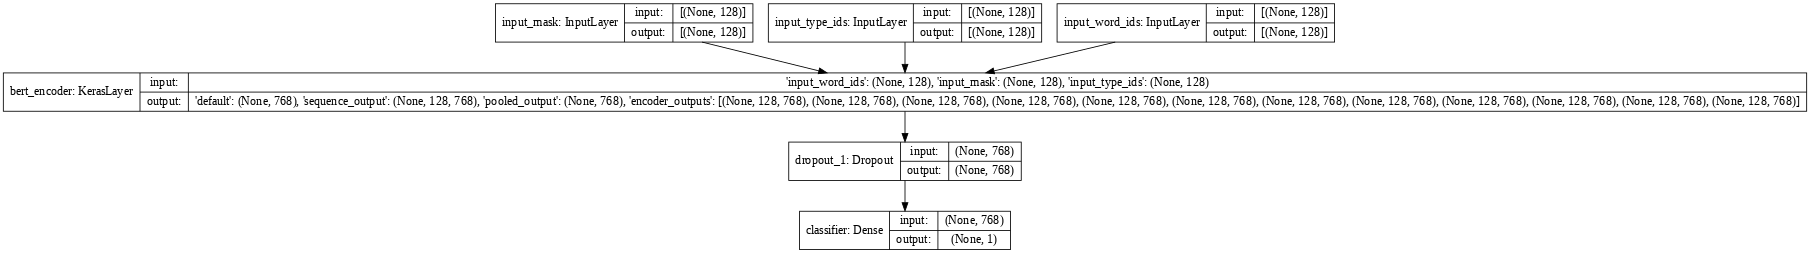

In [26]:
es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_loss',
         mode='min',
         verbose=1,
         save_best_only=True
        )

METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw'
      )

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

##Train

In [27]:
#@title Load Model weights if available
if os.path.exists(checkpoint_root_path) & len(os.listdir(checkpoint_root_path)):
  print('loading saved weight')
  classifier_model.load_weights(model_checkpoint_path)
else:
  print('No weight to initialize') 

No weight to initialize


In [28]:
history = classifier_model.fit(
             x=train_data,
             validation_data=val_data,
             epochs=epochs,
             callbacks=[es, mcb]
             )

Epoch 1/15
608/608 [==============================] - 1099s 2s/step - loss: 0.2688 - tp: 16117.0000 - fp: 1897.0000 - tn: 17880.0000 - fn: 3018.0000 - accuracy: 0.8737 - precision: 0.8947 - recall: 0.8423 - auc: 0.9558 - prc: 0.9567 - val_loss: 0.0980 - val_tp: 3808.0000 - val_fp: 121.0000 - val_tn: 4079.0000 - val_fn: 184.0000 - val_accuracy: 0.9628 - val_precision: 0.9692 - val_recall: 0.9539 - val_auc: 0.9936 - val_prc: 0.9937

Epoch 00001: val_loss improved from inf to 0.09801, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_domain_adapted_all/bert_en_uncased_L-12_H-768_A-12_checkpoint
Epoch 2/15
608/608 [==============================] - 1044s 2s/step - loss: 0.0790 - tp: 18531.0000 - fp: 505.0000 - tn: 19272.0000 - fn: 604.0000 - accuracy: 0.9715 - precision: 0.9735 - recall: 0.9684 - auc: 0.9955 - prc: 0.9953 - val_loss: 0.0827 - val_tp: 3881.0000 - val_fp: 110.0000 - val_tn: 4090.0000 -

In [ ]:
# Save model weights
classifier_model.save_weights(model_checkpoint_path)

#Plot train history

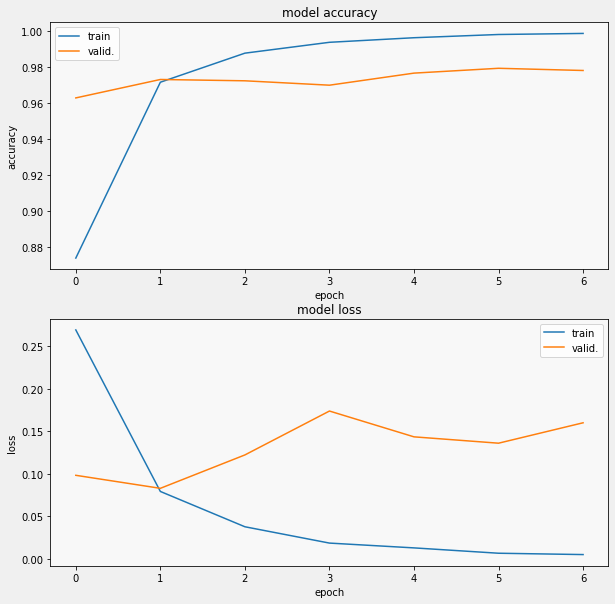

In [29]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

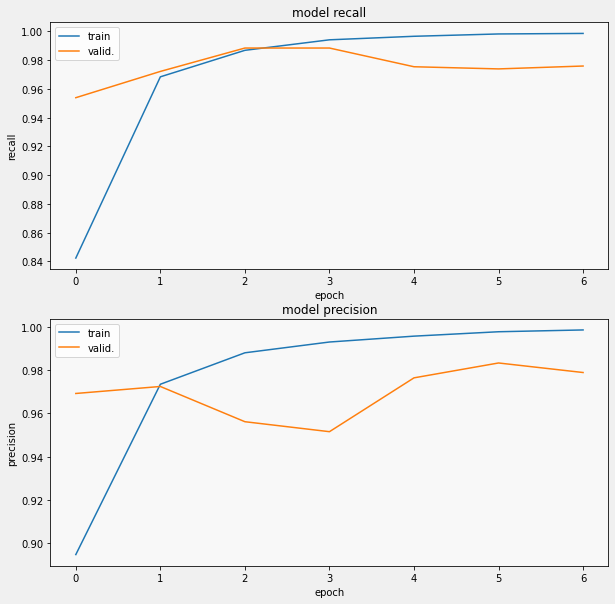

In [30]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

# Model Inference
We have trained the classifier, now let's use the trained model to infer the test dataset. Beside the test dataset, we also have benchmark dataset that we would also to see the eefectiveness of our model over benchmark dataset on predicting the clickbait's.

##Model Evaluation

###Evaluate Classifier on Test set

In [31]:
results_test_set = classifier_model.evaluate(test_data)

for name, value in zip(classifier_model.metrics_names, results_test_set):
  print(name, ': ', value)
print()

30/30 [==============================] - 18s 582ms/step - loss: 0.1053 - tp: 881.0000 - fp: 43.0000 - tn: 980.0000 - fn: 16.0000 - accuracy: 0.9693 - precision: 0.9535 - recall: 0.9822 - auc: 0.9917 - prc: 0.9874
loss :  0.10532470047473907
tp :  881.0
fp :  43.0
tn :  980.0
fn :  16.0
accuracy :  0.9692708253860474
precision :  0.9534631967544556
recall :  0.9821627736091614
auc :  0.9917460680007935
prc :  0.9874124526977539



### Evaluate Classifier on Benchmarking set

In [32]:
results_benchmarking_set = classifier_model.evaluate(benchmark_data)

for name, value in zip(classifier_model.metrics_names, results_benchmarking_set):
  print(name, ': ', value)
print()

2/2 [==============================] - 2s 600ms/step - loss: 0.5731 - tp: 55.0000 - fp: 6.0000 - tn: 47.0000 - fn: 20.0000 - accuracy: 0.7969 - precision: 0.9016 - recall: 0.7333 - auc: 0.9048 - prc: 0.9178
loss :  0.5730829238891602
tp :  55.0
fp :  6.0
tn :  47.0
fn :  20.0
accuracy :  0.796875
precision :  0.9016393423080444
recall :  0.7333333492279053
auc :  0.9047797918319702
prc :  0.9178091883659363



##Export Model for inference

In [33]:
classifier_model.save(saved_model_path, include_optimizer=False)

##Model prediction

In [34]:
saved_classifier = keras.models.load_model(saved_model_path)

### Prediction for Test set

Accuracy: 0.969271
Precision: 0.953463
Recall: 0.982163
F1 score: 0.967600
ROC AUC: 0.970065
[[980  43]
 [ 16 881]]
Non clickbaits Detected (True Negatives):  980
Non-Clickbaits Detected as Clickbaits (False Positives):  43
Clickbaits Detected as Non-clickbaits (False Negatives):  16
Clickbaits Detected (True Positives):  881
Total Non-clickbaits:  1023
Total Clickbaits:  897



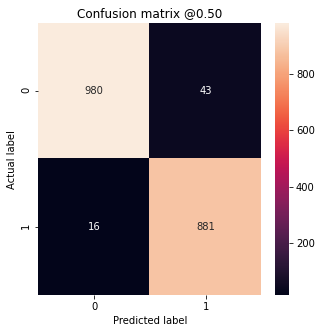

In [35]:
predict_on_test_dataset(saved_classifier, test_data, BATCH_SIZE=BATCH_SIZE)

### Prediction for Benchmarking set

Accuracy: 0.796875
Precision: 0.901639
Recall: 0.733333
F1 score: 0.808824
ROC AUC: 0.810063
[[47  6]
 [20 55]]
Non clickbaits Detected (True Negatives):  47
Non-Clickbaits Detected as Clickbaits (False Positives):  6
Clickbaits Detected as Non-clickbaits (False Negatives):  20
Clickbaits Detected (True Positives):  55
Total Non-clickbaits:  53
Total Clickbaits:  75



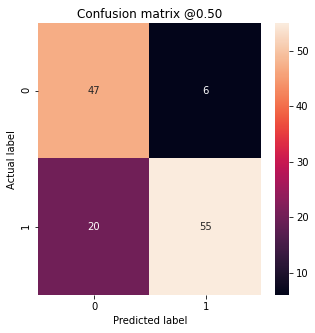

In [36]:
predict_on_test_dataset(saved_classifier, benchmark_data, BATCH_SIZE=BATCH_SIZE)